In [37]:
import os
import cv2
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa
from sklearn.utils import shuffle
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.python.keras.layers import Convolution2D,Flatten,Dense
from tensorflow.python.keras.models import Sequential
from keras import models, layers
from tensorflow.keras.optimizers import Adam

In [38]:
def getfile(filePath):
    return filePath.split('\\')[-1]

In [39]:
def InitData(path):
    columns = ['Center', 'Left', 'Right', 'Steering', 'Throttle', 'Brake', 'Speed']
    data = pd.read_csv(os.path.join(path, "driving_log.csv"), names = columns)
    data['Center'] = data['Center'].apply(getfile)
    print('Total Images Imported', data.shape[0])
    return data

In [40]:
def balanceDataSet(data, display=True):
    nBin = 21
    samplesPerBin = 1000
    hist, bins = np.histogram(data['Steering'], nBin)
    if display:
        center = (bins[:-1] + bins[1:]) * 0.5
        plt.bar(center, hist, width=0.05)
        plt.plot((np.min(data['Steering']), np.max(data['Steering'])), (samplesPerBin, samplesPerBin))
        plt.show()

    removeList = []
    for i in range(nBin):
        binDataList = []
        for j in range(len(data['Steering'])):
            if data['Steering'][j] >= bins[i] and data['Steering'][j] <= bins[i + 1]:
                binDataList.append(j)
        binDataList = shuffle(binDataList)
        binDataList = binDataList[samplesPerBin:]
        removeList.extend(binDataList)
        
    print('Removed Images: ', len(removeList))
    data.drop(data.index[removeList], inplace=True)
    print('Remaining Images: ', len(data))
    
    if display:
        hist, _ = np.histogram(data['Steering'], (nBin))
        plt.bar(center, hist,width=0.05)
        plt.plot((np.min(data['Steering']), np.max(data['Steering'])), (samplesPerBin, samplesPerBin))
        plt.show()

    return data

In [41]:
# Load images and steering angles
def load_images_and_steering(data,path):
    images = []
    steerings = []
    for i in range(len(data)):
        indexed_data = data.iloc[i]
        images.append(os.path.join(path,'IMG',indexed_data[0]))
        steerings.append(float(indexed_data[3]))
    images = np.asarray(images)
    steerings = np.asarray(steerings)
    return images, steerings

In [42]:
def img_preprocess(img):
    img = img[60:135, :, :]  
    img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV) 
    img = cv2.GaussianBlur(img, (3,3), 0) 
    img = cv2.resize(img, (200, 66))  
    img = img / 255.0  
    img = img.astype(np.float32)
    return img
    

In [43]:
def augmentImage(img, steering):
    # img is already a numpy array here
    
    if np.random.rand() < 0.5:
        pan = iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)})
        img = pan.augment_image(img)

    if np.random.rand() < 0.5:
        zoom = iaa.Affine(scale=(1, 1.2))
        img = zoom.augment_image(img)

    if np.random.rand() < 0.5:
        brightness = iaa.Multiply((0.2, 1.2))
        img = brightness.augment_image(img)

    if np.random.rand() < 0.5:
        img = cv2.flip(img, 1)
        steering = -steering
        
    return img, steering

In [44]:
def create_batches(image_paths, steerings, batch_size, is_training):
    while True:
        batch_img = []
        batch_steer = []
        
        for _ in range(batch_size):
            index = random.randint(0, len(image_paths) - 1)
            
            # Load image
            img = mpimg.imread(image_paths[index])
            steering = steerings[index]
            
            # Preprocess FIRST
            img = img_preprocess(img)
            
            # Then augment if training
            if is_training:
                img, steering = augmentImage(img, steering)
            
            batch_img.append(img)
            batch_steer.append(steering)

        yield (np.asarray(batch_img), (np.asarray(batch_steer)))



In [45]:
def driving_angle_model():
    net = models.Sequential([
                        # Original size passing the first CNN
                        # With 24 filters, this extracts features such as edges and textures
                        layers.Conv2D(filters=24, kernel_size=(5, 5), activation='relu', input_shape=(66,200,3)),
                        
                        # With 36 filters, this extracts deeper features such as lane curves
                        layers.Conv2D(filters=36, kernel_size=(5, 5), activation='relu'),

                        # With 48 layers, this extracts high level features such as lane patterns
                        layers.Conv2D(filters=48, kernel_size=(5, 5), activation='relu'),

                        # With 64 layers, this extracts fine grained features
                        layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),

                        # Once again at 64 filters, this extracts the previous features once more
                        layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),

                        # Flatten the result array to a 1D array to match size for Dense
                        layers.Flatten(),

                        # Separate 3 Dense compressions on result layer
                        # Compressing with large number of neurons will overfit, and too low will underfit or lose info
                        layers.Dense(100, activation='relu'),
                        layers.Dense(50, activation='relu'),
                        layers.Dense(1)
                        ])
    
    optimizer = Adam(learning_rate=1e-4)

    # We want to determine the driving angle based on picture. Therefore, this is a regression problem
    net.compile(optimizer=optimizer, loss=MeanSquaredError())

    return net

Total Images Imported 29006


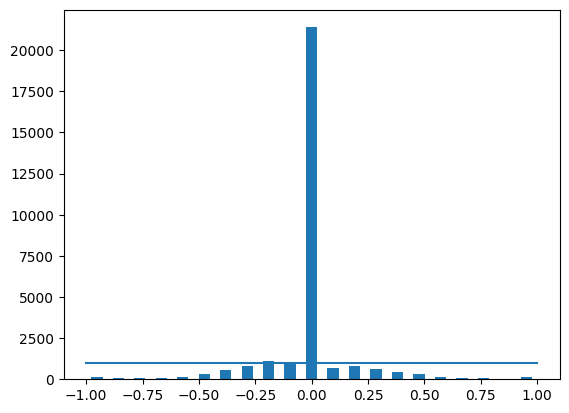

Removed Images:  20506
Remaining Images:  8500


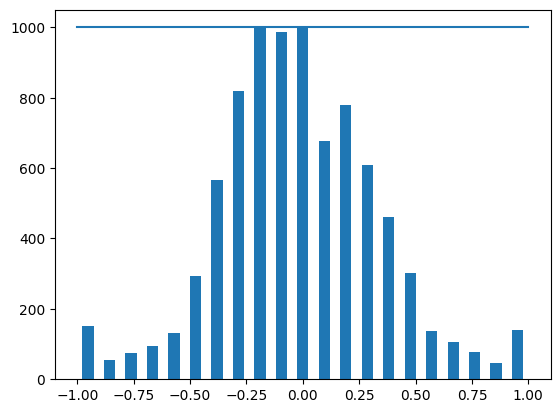

C:\Users\yingt\AppData\Local\Temp\ipykernel_70996\108753019.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  images.append(os.path.join(path,'IMG',indexed_data[0]))
C:\Users\yingt\AppData\Local\Temp\ipykernel_70996\108753019.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  steerings.append(float(indexed_data[3]))
c:\Users\yingt\OneDrive\Desktop\CVI620\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 51s 987ms/step - loss: 0.2806 - val_loss: 0.0978
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 46s 929ms/step - loss: 0.1062 - val_loss: 0.0824
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 47s 932ms/step - loss: 0.0954 - val_loss: 0.0746
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 48s 956ms/step - loss: 0.0827 - val_loss: 0.0756
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - loss: 0.0835 - val_loss: 0.0911
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - loss: 0.0844 - val_loss: 0.0763
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 47s 938ms/step - loss: 0.0703 - val_loss: 0.0849
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 47s 936ms/step - loss: 0.0695 - val_loss: 0.0682
Epoch 9/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 47s 932ms/step - loss: 0.0670 - val_loss: 0.0774
Epoch 10/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 47s 945ms/step - loss: 0.0713 - val_loss: 0.0681


In [46]:
data = InitData('.')
data = balanceDataSet(data, display=True)

image_path, steerings = load_images_and_steering(data, '.')

X_train, X_test, y_train, y_test = train_test_split(image_path, steerings, test_size=0.2, random_state=42)

net = driving_angle_model()

# Fits the neural network with data
# Batch size between 2-32 can consistently be stable and reliable (source: Revisiting Small Batch Training for Deep Neural Networks)
H = net.fit(create_batches(X_train, y_train, 32, 1), steps_per_epoch=50, epochs=10, validation_data=create_batches(X_test, y_test, 100, 0), validation_steps=12)

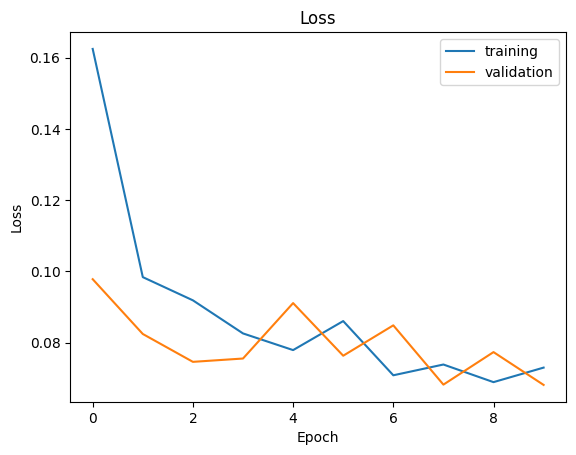

In [47]:
plt.plot(H.history["loss"], label="training")
plt.plot(H.history["val_loss"], label="validation")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [48]:

net.save('model.h5')